# Extracting Reddit Data for Research

## Workshop by Alejandro Hermida Carrillo and Melody Sepaphour-Fard

In [1]:
"""
Load the necessary modules
"""
import requests as rq ## Basic library for acce
import json
import time
import sys ## for printing only
import pandas as pd


In [2]:
"""
Define the working directory
"""
import os
os.chdir(r"/Users/hermida/Dropbox/Mini projects/Workshop Reddit") #Change to your own WD
print("Current Working Directory " , os.getcwd())

Current Working Directory  c:\Users\hermida\Dropbox\Mini projects\Workshop Reddit


In [3]:
"""
Define constants
"""
iteration_max = 10 #Max number of retries if request fails 
retry_delay = 10  #Time to new request if an the last request ends in an error
url = 'https://api.pushshift.io/reddit/search/' #This is the url common to both endpoints

In [4]:
"""
Define functions

"""

def parse_date(date, format='human'):
    """"
    This function takes a string and converts it into either a human readable date format or epoch date format. It is particularly useful to add an after and before arguments to the payload
    
    Parameteres:
    ============
    date: str
        A string with either epoch date format or human readable date format.

    format: str
        A string defining the format of the input string. By default, it takes the value 'human' and the other option is 'epoch'.
    """
    if format == 'human':
        pattern = '%Y-%m-%d %H:%M:%S'
        return str(int(time.mktime(time.strptime(date, pattern))))
    elif format == 'epoch':
        pattern = '%Y-%m-%d %H:%M:%S'
        return time.strftime(pattern, time.localtime(int(date)))

def collect_data(source_url, payload,iteration_count=0):
    """
    This function takes the Pushift endpoint and payload as arguments and sends a request to the URL. Depending on the status code it either returns 
    the list of mappings, a status code, or sleeps for 60 seconds and tries again to get the data.
    
    Parameters:
    ===========
    source_url: str
        A string with the url of the Pushshift API endpoint.

    payload: 
        A mapping with parameters passed to the Pushshift API endpoint.

    iteration_count:
        An integer. It increases by one in each extra iteration after an error is found. If it exceeds the pre-defined iteration_max parameter, the function stops.
    """

    if 'after' not in payload:
        payload['after'] = parse_date('2005-06-23 00:00:00')  #If an "after" date is not provided in the payload, this is set to the creation of Reddit
    headers = {'user-agent': 'lmu-crawler/1'}                 #Identify your crawler
    response = rq.get(source_url, params = payload, headers=headers)
    if response.status_code == 200:
        time.sleep(1)
        return json.loads(response.text)['data']                                                           #Saves only the data 
    elif (response.status_code == 429 or response.status_code == 523 or response.status_code == 522 or     #429: Too many requests; 523: Proxy declined request
            response.status_code == 525 or response.status_code == 502 or response.status_code == 500):    #525: Unable to establish a secure connection
        if iteration_count > iteration_max:                                                                #Iteration_max prevents infinite loops
            print(f"Number of max iterations {str(iteration_max)} exceeded")
            return [{'status' : response.status_code, 'message' : response.content }]
        time.sleep(retry_delay)
        #for i in range(60,0,-1):
        print(f"The compulsory break finishes in {str(retry_delay)} seconds. Error: "+str(response.status_code))
        print(response.headers)
        return collect_data(source_url = source_url, payload = payload, iteration_count = iteration_count + 1) 
    else:
        return [{'status' : response.status_code, 'message' : response.content }]


def get_submissions(file_to_append, endpoint = 'submissions', index=0,delete_json =True):
    """
    This function takes a file name as an argument. It appends the data obtained using the collect_data function in a json file and saves a CSV with the content.

    Parameters:
    ===========
    file_to_append: string
        String naming the file to which each individual reddit submission will be appended as a standalone json object. The same name will be used to save the CSV file.
    
    endpoint: string
        Takes two possible values, submissions (default) or comments. This determines which information will be obtained by calling one of the two different endpoints of the pushift API. 

    delete_json = boolean
        If True, deletes the json file from the working directory
    """
    if endpoint.lower() != 'comments' and endpoint.lower() != 'submissions':
        print(r"This function only accepts 'comments' or 'submissions' in the endpoint argument. You wrote: " + endpoint.lower())
        sys.exit()
    else:
        print('\n',"Searching for all "+ endpoint + " in the subreddit " + payload['subreddit'] + " from " + parse_date(payload['after'],format = 'epoch') + " to " + parse_date(payload['before'],format = 'epoch'),end='')
        pass
    source_url = url+ endpoint[:-1].lower() + '/'
    time.sleep(index*5)
    file_jl = file_to_append + '_'+ endpoint + '.jl'
    count = 1
    with open(file_jl, 'w') as file_json:
        try:
            comments = collect_data(source_url = source_url, payload = payload)
            ## For the first batch of N results (N specified in the "size"argument of the payload)
            # If comments is non-empty
            if len(comments) > 0:
                for line in comments:
                    if 'created_utc' in line: #Do we have a post with a date?
                        line['created_utc'] = parse_date(line['created_utc'], format = 'epoch') #Transform it to human-readable form
                        file_json.write(json.dumps(line) + '\n') #Dump the information retrieved in the Json file 
                    else:
                        pass
                ## If comments is non-empty
                while len(comments) > 0:
                    ## Check if we got data from Reddit or a strange status code
                    if len(comments[0].keys()) > 2: ## More than 2 variables recovered?
                        ## Make the last collected data date in epoch time the "after" parameter of the payload
                        payload['after'] = parse_date(comments[-1]['created_utc'])
                        print('\n','New after date: ' +parse_date(payload['after'],format = 'epoch'),end='')
                        ## Collect the data again, now using the updated "after" date in the payload
                        comments = collect_data(source_url = source_url, payload = payload)
                        for line in comments:
                            if 'created_utc' in line:
                                line['created_utc'] = parse_date(line['created_utc'], format = 'epoch')
                                try:
                                    print('\r','Saving submission number ' + str(count),end='')
                                    file_json.write(json.dumps(line) + '\n')
                                    count += 1
                                except:
                                    print("Unexpected error:", sys.exc_info()[0])
                                    raise
                    else:
                        ## Print out the strange status code and its message
                        print(f'Something went wrong. The status code error was {comments.pop()}.')
                else:
                    pass
        except:
            print("Unexpected general error:", sys.exc_info())
            raise
    data_json = pd.read_json(file_jl, lines = True)
    print(data_json.head())
    data_json.to_csv(file_to_append+ '_'+ endpoint + '.csv')
    if delete_json:
        os.remove(file_jl)


## The payload

The payload will define what information do we search in the chosen endpoint. For example, if we use the "submissions" endpoint, we can search submissions... 

1. of specific users, 
2. in specific subreddits, 
3. before / after a specific time, 
4. using certain keywords,
5. a combination of all the above.  

By using a source_url ending in "comment" instea of "submission" we call for that endpoint and search for comments instead.
For more information, check out the API documentation in https://github.com/pushshift/api.


In [33]:
"""
Using the collect_data function
"""
posts = collect_data(source_url = url + 'submission/',                                              #Use the submission endpoint
                                        payload = { 'q' : 'science',                                #Search for a keyword (NOT case sensitive)
                                                    'subreddit' : 'futurology',                    #Within a given subreddit
                                                    'after' : parse_date('2021-12-10 14:25:26'),    #After a certain date
                                                    'before' : parse_date('2022-01-27 00:00:00'),   #An before a second date
                                                    'sort_type' : "created_utc",                    #Order the output by creation time
                                                    'size' : 5})                                    #Return 5 results (Max = 500)
posts

[{'all_awardings': [],
  'allow_live_comments': False,
  'author': 'Straight_Finding_756',
  'author_flair_css_class': None,
  'author_flair_richtext': [],
  'author_flair_text': None,
  'author_flair_type': 'text',
  'author_fullname': 't2_by9x705g',
  'author_is_blocked': False,
  'author_patreon_flair': False,
  'author_premium': True,
  'awarders': [],
  'can_mod_post': False,
  'contest_mode': False,
  'created_utc': 1639598625,
  'domain': 'arcinstitute.org',
  'full_link': 'https://www.reddit.com/r/Futurology/comments/rh7yw6/arc_institute_arc_institute_a_new_institution_for/',
  'gildings': {},
  'id': 'rh7yw6',
  'is_created_from_ads_ui': False,
  'is_crosspostable': True,
  'is_meta': False,
  'is_original_content': False,
  'is_reddit_media_domain': False,
  'is_robot_indexable': True,
  'is_self': False,
  'is_video': False,
  'link_flair_background_color': '',
  'link_flair_css_class': 'biotech',
  'link_flair_richtext': [],
  'link_flair_template_id': 'dc868cc6-e558-11e6-8

# Some relevant fields returned
*For both comments and submissions*
1. **id** includes the unique identifier of the post 
3. **created_utc** contains the timestamp
4. **author** the name of the author who wrote the post
5. **author_fullname** the unique identifier of the author

*For submissions*
1. **title** is the headline of the post
2. **selftext** contains the body of the text
3. **is_self** indicates if the content links to an external site. In subreddits heavy on text, this can be used to filter paid posts
4. **over_18** content tagged as NSFW

*For comments*
1. **parent_id** contains the id of the submissions this comment is responding to 
2. **body** contains the body of the text

However, the API returns many interesting fields we have not explored yet, such as author characteristics

In [6]:
"""
Accessing all the fields
"""
posts[0].keys()

dict_keys(['all_awardings', 'allow_live_comments', 'author', 'author_flair_css_class', 'author_flair_richtext', 'author_flair_text', 'author_flair_type', 'author_fullname', 'author_is_blocked', 'author_patreon_flair', 'author_premium', 'awarders', 'can_mod_post', 'contest_mode', 'created_utc', 'domain', 'full_link', 'gildings', 'id', 'is_created_from_ads_ui', 'is_crosspostable', 'is_meta', 'is_original_content', 'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 'is_video', 'link_flair_background_color', 'link_flair_css_class', 'link_flair_richtext', 'link_flair_template_id', 'link_flair_text', 'link_flair_text_color', 'link_flair_type', 'locked', 'media_only', 'no_follow', 'num_comments', 'num_crossposts', 'over_18', 'parent_whitelist_status', 'permalink', 'pinned', 'post_hint', 'preview', 'pwls', 'retrieved_on', 'score', 'selftext', 'send_replies', 'spoiler', 'stickied', 'subreddit', 'subreddit_id', 'subreddit_subscribers', 'subreddit_type', 'thumbnail', 'thumbnail_height', '

In [7]:
"""
Author variables returned
"""
dict(filter(lambda item: item[0].startswith('author'),
                                          posts[0].items()))

{'author': 'Straight_Finding_756',
 'author_flair_css_class': None,
 'author_flair_richtext': [],
 'author_flair_text': None,
 'author_flair_type': 'text',
 'author_fullname': 't2_by9x705g',
 'author_is_blocked': False,
 'author_patreon_flair': False,
 'author_premium': True}

## Pulling all available posts
The search is limited to a maximum of 500 results. The get_submissions function sends requests iteratively while pushing the after argument closer to the before until the search returns no result.

In [8]:
payload = { 'subreddit' : 'antiwork',
            'after' : parse_date('2022-03-03 00:00:00'),
            'before' : parse_date('2022-03-06 00:00:00'),
            'sort_type' : "created_utc",                   #Start by the oldest (default: most recent)
            'size' : 500}                                  #Maximum size (500)

get_submissions('test',
                endpoint='submissions')


 Searching for all submissions in the subreddit antiwork from 2022-03-03 00:00:00 to 2022-03-06 00:00:00Unexpected general error: (<class 'KeyboardInterrupt'>, KeyboardInterrupt(), <traceback object at 0x0000015DB2FC2E48>)


KeyboardInterrupt: 

In [21]:
df = (pd.read_csv('test_submissions.csv').
      loc[:,["id","author", "created_utc","title"]])
print(df.head())

       id                author          created_utc  \
0  t5cp0x            Animalpoop  2022-03-03 00:01:01   
1  t5cpv3  Strange_Knowledge_98  2022-03-03 00:02:06   
2  t5cq3u             MegaMissy  2022-03-03 00:02:26   
3  t5cs9k       bigtiddygothgf3  2022-03-03 00:05:09   
4  t5cslv                trb310  2022-03-03 00:05:34   

                                               title  
0      Put in my two weeks today to pursue my music.  
1  I make 6-figures and my job is literally point...  
2  Mardi Gras was canceled in 2021 due to Covid. ...  
3  Stolen from an Instagram meme page, sort of fu...  
4                        Employee appreciation socks  


## Manipulating the data

The get_submissions function saves a csv in the working directory. This can then be used for any further analyses in Python or other environments

## Excercise 

Download the last three days of data from your favorite subreddit and explore the descriptives of your choice. E.g., how many different authors posted? How does the distribution of contributions look like?

### Example solution


In [22]:
#number of posts
print(f"The dataset contains {len(df)} posts")
#number of unique authors
print(f'The dataset contains {len(df["author"].unique())} unique authors')
#Date range 
print(f'The posts were written between the '+ min(df['created_utc']) + ' and the '+ max(df['created_utc']))

The dataset contains 2171 posts
The dataset contains 1972 unique authors
The posts were written between the 2022-03-03 00:01:01 and the 2022-03-05 23:59:43


In [23]:
#See how active the authors are 
from collections import Counter
authors_activity = Counter(df["author"])
sorted_authors_activity = {k: v for k, v in sorted(authors_activity.items(), key=lambda item: item[1])}
df_activity = pd.DataFrame(list(sorted_authors_activity.items()),columns = ['author','nb of comments'])
df_activity["nb of comments"].describe()

count    1972.000000
mean        1.100913
std         0.468662
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        11.000000
Name: nb of comments, dtype: float64

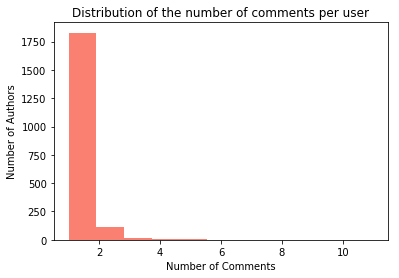

In [24]:
#plot the distribution of the number of comments per user
import matplotlib.pyplot as plt
# matplotlib histogram
plt.hist(df_activity['nb of comments'], color = 'salmon',
         bins = int(max(df_activity['nb of comments'])))


# Add labels
plt.title("Distribution of the number of comments per user")
plt.xlabel('Number of Comments')
plt.ylabel('Number of Authors')
plt.show()

In [25]:
#Clean the data

import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

#Functions to be used
#First round of text cleaning techniques
def clean_text_round1(text):
    """
    Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.
    """
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub("[^\u0000-\u05C0\u2100-\u214F]+",'', text)
    return text

#Second round of cleaning
def clean_text_round2(text):
    """
    Get rid of some additional punctuation and non-sensical text that was missed on the first round.
    """
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

round2 = lambda x: clean_text_round2(x)

round1 = lambda x: clean_text_round1(x)

#Tokenize
def tokenize(text):
    tokens = word_tokenize(text)
    return tokens

#Lemmatize 
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in text]

In [26]:
# Download the data necessary to lemmatize
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\la\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [27]:
#remove stopwords
from sklearn.feature_extraction import text
add_stop_words = ['have','went','im','theyre'] #if you want to add stopwords
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

#remove stopwords from tokenized dataset
df = df[df['title'].notna()]
df['preprocessed']= (df['title'].copy().
                     apply(round1).
                     apply(round2).
                     apply(tokenize).
                     apply(lambda x: [item for item in x if item not in stop_words]).
                     apply(lemmatize_text))

print(df['preprocessed'][:10])

0                         [week, today, pursue, music]
1                    [make, job, literally, pointless]
2    [mardi, gras, canceled, covid, dont, blame, cl...
3    [stolen, instagram, meme, page, sort, funny, r...
4                       [employee, appreciation, sock]
5    [actual, audacity, force, employee, continue, ...
6                              [toxic, manager, trait]
7                              [like, dont, read, say]
8    [idea, dont, really, need, job, shit, job, bos...
9    [idea, dont, really, need, job, shit, job, bos...
Name: preprocessed, dtype: object


In [28]:
#The most frequent words in our corpus
from nltk.probability import FreqDist

#iterate through each comment, then each token in each comment, and store in one list
flat_words = [item for sublist in df["preprocessed"] for item in sublist]

word_freq = FreqDist(flat_words)

# 30 most frequent words
word_freq.most_common(30)

[('work', 279),
 ('job', 249),
 ('just', 145),
 ('bos', 115),
 ('company', 109),
 ('day', 105),
 ('employee', 104),
 ('pay', 89),
 ('people', 83),
 ('time', 82),
 ('worker', 80),
 ('need', 77),
 ('got', 77),
 ('dont', 76),
 ('want', 76),
 ('like', 72),
 ('working', 70),
 ('year', 69),
 ('make', 66),
 ('week', 63),
 ('wage', 60),
 ('manager', 60),
 ('raise', 58),
 ('quit', 57),
 ('today', 56),
 ('employer', 55),
 ('hour', 51),
 ('new', 50),
 ('office', 45),
 ('say', 44)]

## Further links

- Pushshift API [documentation](https://github.com/pushshift/api)